# Final Project - Part 1

### Libraries
Here we include all python-native and conda-bundled libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import numpy as np
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


Helper functions for our project can be found in `scripts/helpers.py`. We refactor the common functions, e.g. function to read dataset file, in order to provide reusability and to reduce redudancy in our main notebook.

In [2]:
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe, copy_dataframe

### Datasets
We mainly use million songs datasets (msd), the msd provide two big datasets:
* msd_songs 
* msd_summary

<br>We read dataset using our predefined read_raw_dataset() function:

In [3]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")

Peek into the dataset using predefined debug_dataframe() function:

In [4]:
# debug dataframe msd_songs
debug_dataframe(df_msd_songs)

Dataset size:  (1000000, 11)
Dataset feature columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year'],
      dtype='object')

Dataset Preview:


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006


In [5]:
# debug dataframe msd_summary
debug_dataframe(df_msd_summary)

Dataset size:  (1000000, 53)
Dataset feature columns:  Index(['analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_id', 'analyzer_version',
       'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_mbid', 'artist_name', 'artist_playmeid', 'genre',
       'idx_artist_terms', 

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,idx_artist_mbtags,year
0,22050,aee9820911781c734e7694c5432990ca,0.0,252.05506,2.049,0.0,0,0,0,0,...,0,0,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,0,2003
1,22050,ed222d07c83bac7689d52753610a513a,0.0,156.55138,0.258,0.0,0,0,0,0,...,0,0,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,0,1995
2,22050,96c7104889a128fef84fa469d60e380c,0.0,138.97098,0.000,0.0,0,0,0,0,...,0,0,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,0,2006


#### Datasets observation
* Dataset consist of exactly one million datapoints.
* Column "track_id" is used as key (Primary Key) which is always unique and will be useful for join operation.
* Each datapoint (song) has 9 main attributes in msd_songs and 42 additional attributes in msd_summary. This makes all songs have 51 features (52 including track_id).
* Our projects aim to observe trend of "popular songs", therefore we will mainly work with msd_songs since msd_summary mostly contains features that we may not really need.
* Main observations of the rest of the project will most likely deal with "song_hotttnesss", as this field relates to the popularity of a song. 

## Data Preprocessing & Initial Features Analysis

From msd dataset, we get the information of exactly one million songs data with 52 features each (track_id, song_hotttnesss, artist_hotttnesss, year, artist_id, and so on). Now for the first part, we want to investigate the attributes that lead to song popularity. We define our dataset as pairs of:

$$ (x_n, y_n) $$
where:
$$ y_n := \text{n'th song hotttnesss} $$
$$ x_n := \text{n'th vector of D features} $$
$$ D = 51 $$

First set "track_id" as index for both dataframe

In [6]:
# Set index for both dataframe
df_msd_songs   = df_msd_songs.set_index(["track_id"])
df_msd_summary = df_msd_summary.set_index(["track_id"])

Next figure out unique columns in msd_summary to avoid redundant columns when merging dataframe

In [7]:
# Use columns which are present in msd_summary but not in msd_songs
msd_summary_cols = df_msd_summary.columns.difference(df_msd_songs.columns)
len(msd_summary_cols)

42

Then we need to merge both dataframe as single df_msd based on track_id

In [8]:
# perform inner join based on index (track_id)
df_msd = pd.concat([df_msd_songs, df_msd_summary[msd_summary_cols]], axis=1, join='inner')

Debug the result

In [9]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 52)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'analysis_sample_rate', 'analyzer_version', 'artist_7digitalid',
       'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_playmeid', 'audio_md5', 'danceability', 'end_of_fade_in',
       'energy', 'genre', 'idx_artist_mbtags', 'idx_artist_terms',
       'idx_bars_confidence', 'idx_bars_start', 'idx_beats_confidence',
       'idx_beats_start', 'idx_sections_confidence', 'idx_sections_start',
       'idx_segments_confidence', 'idx_segments_loudness_max',
       'idx_segments_loudness_max_time', 'idx_segments_loudness_start',
       'idx_segments_pitches', 'idx_segments_start', 'idx_segments_timbre',
       'idx_similar_artists', 'idx_tatums_confidence', 'idx_tatums_start',
       'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence',
       'relea

,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,-4.829,0,0.688,633681,0.542899,236.635,87.002,4,0.940,7032331
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,-10.555,1,0.355,145266,0.299877,148.660,150.778,1,0.000,1514808
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,-2.060,1,0.566,625706,0.617871,138.971,177.768,4,0.446,6945353


Find and plot the correlation between features using heatmap

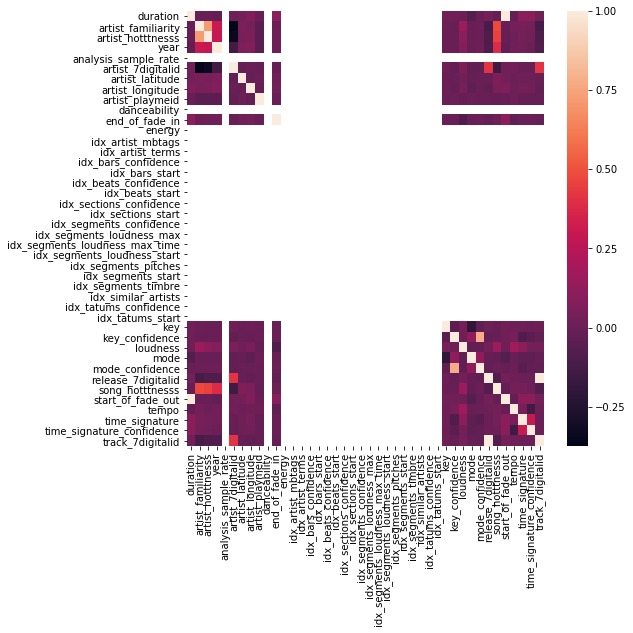

In [10]:
msd_corr = df_msd.corr()
fig, ax  = plt.subplots(figsize=(8,8))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, ax = ax)
plt.show()

#### Analyzing useless features
From above correlation chart, we can infer that some features do not give impact or relation to other attributes. Those features are: 
> ['analysis_sample_rate', 'danceability', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'idx_artist_terms',
       'idx_similar_artists', 'idx_artist_mbtags']

So we then analyze if either the value of these features are unique or not. If a feature is unique for the entire datapoints, we can ignore it and drop it to narrow our analysis.

In [11]:
# List of unrelated features
unrelated_features = ['analysis_sample_rate', 'audio_md5', 'danceability','energy', 'idx_bars_confidence', 
                      'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence', 
                      'idx_sections_start', 'idx_segments_confidence', 'idx_segments_loudness_max', 
                      'idx_segments_loudness_max_time', 'idx_segments_loudness_start', 'idx_segments_pitches', 
                      'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence', 'idx_tatums_start', 
                      'idx_artist_terms', 'idx_similar_artists', 'idx_artist_mbtags']

# define function to check unrelated features uniqueness 
def is_feature_unique(df, features):
    for feature in features:
        unique_value = df[feature].unique()
        if len(unique_value) == 1:
            print(feature + " is unique, only: " + str(unique_value[0]))

# check and print the unique features
is_feature_unique(df_msd, unrelated_features)

analysis_sample_rate is unique, only: 22050
danceability is unique, only: 0.0
energy is unique, only: 0.0
idx_bars_confidence is unique, only: 0
idx_bars_start is unique, only: 0
idx_beats_confidence is unique, only: 0
idx_beats_start is unique, only: 0
idx_sections_confidence is unique, only: 0
idx_sections_start is unique, only: 0
idx_segments_confidence is unique, only: 0
idx_segments_loudness_max is unique, only: 0
idx_segments_loudness_max_time is unique, only: 0
idx_segments_loudness_start is unique, only: 0
idx_segments_pitches is unique, only: 0
idx_segments_start is unique, only: 0
idx_segments_timbre is unique, only: 0
idx_tatums_confidence is unique, only: 0
idx_tatums_start is unique, only: 0
idx_artist_terms is unique, only: 0
idx_similar_artists is unique, only: 0
idx_artist_mbtags is unique, only: 0


#### Dropping features
From above results, we drop these features:
* 'analysis_sample_rate' 
* 'danceability'
* 'energy'
* 'idx_bars_confidence' 
* 'idx_bars_start'
* 'idx_beats_confidence'
* 'idx_beats_start'
* 'idx_sections_confidence'
* 'idx_sections_start'
* 'idx_segments_confidence'
* 'idx_segments_loudness_max'
* 'idx_segments_loudness_max_time'
* 'idx_segments_loudness_start'
* 'idx_segments_pitches'
* 'idx_segments_start'
* 'idx_segments_timbre'
* 'idx_tatums_confidence'
* 'idx_tatums_start'
* 'idx_artist_terms'
* 'idx_similar_artists'
* 'idx_artist_mbtags'

*Dropping features md5*
<br>From the [dataset description](https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description), we decide to drop feature md5:
* 'audio_md5' | string | audio hash code : DROP (useless)

Thus, we drop all unrelated_features

In [12]:
df_msd = df_msd.drop(unrelated_features, axis=1)

Replot the correlation heatmap

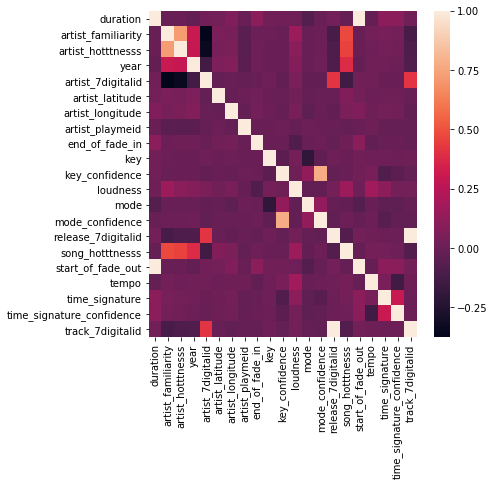

In [13]:
msd_corr = df_msd.corr()
fig, ax  = plt.subplots(figsize=(6,6))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, ax = ax)
plt.show()

See what's left on msd dataframe are:

In [14]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 30)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'analyzer_version', 'artist_7digitalid', 'artist_latitude',
       'artist_location', 'artist_longitude', 'artist_playmeid',
       'end_of_fade_in', 'genre', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'release_7digitalid', 'song_hotttnesss',
       'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_7digitalid'],
      dtype='object')

Dataset Preview:


,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,-4.829,0,0.688,633681,0.542899,236.635,87.002,4,0.940,7032331
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,-10.555,1,0.355,145266,0.299877,148.660,150.778,1,0.000,1514808
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,-2.060,1,0.566,625706,0.617871,138.971,177.768,4,0.446,6945353


At this point, we have reduced the dimension of msd datasets size from 1000000 x 52 into **1000000 x 30**

#### Handling NAN values in song_hotttnesss
*Recall that songs popularity is measured in "song_hotttnesss" column.* As we want to explore more about the correlations between other features and this value, there is no point in keeping entries which do not have this value.
<br>We inspect how many NaN values we have and then remove the all datapoints with NaN value in "song_hotttnesss".

In [15]:
NAN_entries = (df_msd.song_hotttnesss.isnull()).sum()
print("datapoints with song_hotttnesss equals to NaN: ", NAN_entries)

datapoints with song_hotttnesss equals to NaN:  418035


It's dissapointed to know that almost 50% of the datapoints have no song_hotttnesss value. Despite of that, now we remove the NAN.

In [16]:
df_msd_without_nan = df_msd[~df_msd.song_hotttnesss.isnull()]
# check how much datapoints we have
print("datapoints left: ", df_msd_without_nan.shape[0])

datapoints left:  581965


#### Save the reduced dataframe into pickle file

In [17]:
save_dataframe(df_msd_without_nan,"df_msd_reduced")

#### Load the reduced dataframe pickle file

In [18]:
# Read pickle file and form the dataframe object
df_msd_reduced = read_saved_dataframe("df_msd_reduced")
df_msd_reduced.shape

(581965, 30)

# Solution to our first research questions

**Recall that songs popularity is measured in "song_hotttnesss" column.** By using reduced msd dataset (with 40 columns), we can start to answer the research questions. 
<br>In addition, as we have interest with popular songs, we take only top songs based on song_hotttnesss in the last ten years  from datasets collection year (2001-2010). We also pick less popular songs (**up to 10000 songs**) to compare the data and draw valid analysis.

We define and add label based on song_hotttness as follows:
1. Popular : 
$$ song\_hotttnesss \geq 0.80 $$
2. Unpopular: 
$$ song\_hottnesss < 0.80 $$

**Get last 10 years songs from 2001-2010.**

In [19]:
# take top songs from 2001
df_msd_latest_songs = df_msd_reduced.loc[(df_msd_reduced["year"] > 2000)]

**Get popular songs from 2001-2010.**

In [22]:
# take top songs from 2001
df_msd_top    = copy_dataframe(df_msd_latest_songs)
df_msd_top    = df_msd_top.loc[(df_msd_top["song_hotttnesss"] >= 0.8)]

# add label
df_msd_top["popularity"] = "popular"

**Get less popular songs from 2001-2010.**

In [29]:
# take unpopular songs from 2001
df_msd_less = copy_dataframe(df_msd_latest_songs)
df_msd_less = (df_msd_less.loc[(df_msd_less["song_hotttnesss"] < 0.8)]).head(10000)

# add label
df_msd_less["popularity"] = "unpopular"

**Merge dataframe and save the file.**

In [30]:
df_msd_1 = pd.concat([df_msd_top, df_msd_less])
save_dataframe(df_msd_1,"df_msd_1")

#### Load popular and less populars songs from (2001-2010)

In [31]:
# Read pickle file and form the dataframe object
df_msd_1 = read_saved_dataframe("df_msd_1")
print("dataset size: ", df_msd_1.shape)

dataset size:  (15368, 31)


## Q1.1 What is the characteristic/metrics of popular songs?
In this part, we want to find the features which lead to the popularity of the song. In order to find the important feature, we propose to use random forest to predict whether this song is popular/unpopular. Once we get high accuracy by random forest, we observe the attribute **feature\_importances** to see which feature matters the most. Lastly, we combine our common sense to see whether the result got from random forest is reasonable.

First let's see from numbers, which features correspond significantly to song_hotttnesss.

In [34]:
# Use corr() built-in panda to see data correlation between song_hotttnesss and others columns.
msd_corr_song_hotnes = df_msd_1.corr().loc[["song_hotttnesss"]]
display(msd_corr_song_hotnes.iloc[:,:10])
display(msd_corr_song_hotnes.iloc[:,10:])

,duration,artist_familiarity,artist_hotttnesss,year,artist_7digitalid,artist_latitude,artist_longitude,artist_playmeid,end_of_fade_in,key
song_hotttnesss,-0.032032,0.658641,0.646129,0.189801,-0.143919,0.047171,-0.061258,-0.031276,0.004815,0.006697


,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
song_hotttnesss,0.027077,0.182259,-0.014546,0.048541,-0.035237,1.0,-0.033839,0.027006,0.044252,0.04724,-0.034993


Briefly, we can see that "artist_familiarity", "artis_hotttnesss", "year", and "loudness" have more correlations with "song_hotttness"

Next define (x,y) for RandomForestClassifier

In [35]:
unused_features = ['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
                       'artist_name', 'analyzer_version', 'artist_location', 'genre']
unused_features.append("song_hotttnesss")
unused_features.append("popularity")

x = df_msd_1.drop(unused_features, axis=1)
y = df_msd_1.popularity

In [36]:
# check if we have nan or not in x dataframe
x.isnull().values.any()

True

In [37]:
# fill the rest of missing values with mean
x = x.fillna(x.mean())

In [38]:
# check the data
print(x.shape)
print(y.shape)

(15368, 20)
(15368,)


In [39]:
# split the original dataset into 20% validation set, 10% test set and 80% training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# split the test set into 50% validation set and 50% test set (both are 10% of the original dataset)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [40]:
# variables to store the best parameters and model
best_fscore_tr = fscore = best_fscore = best_n_estimators = best_max_depth = 0

n1 = 15
n2 = 3

n_estimators_arr = [i*100 + 100 for i in range(n1)]
max_depth_arr = [i*10 + 10 for i in range(n2)]
fscore_test_array = np.zeros([n1,n2])
fscore_train_array = np.zeros([n1,n2])

# grid search the best parameters
for i, n_estimators in enumerate(n_estimators_arr):
    for j, max_depth in enumerate(max_depth_arr):

        # build the model and train
        clf = RandomForestClassifier(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     n_jobs=4)
        clf.fit(x_train, y_train)

        # test the performance with validation set
        # 'macro' means calculating metrics for each label, and finding their unweighted mean
        fscore = fscore_test_array[i,j] = f1_score(y_val, clf.predict(x_val), average = 'macro')
        fscore_train_array[i,j] = f1_score(y_train, clf.predict(x_train), average = 'macro')
        
        # record the best one
        if fscore > best_fscore:
            best_fscore = fscore
            best_fscore_tr = fscore_train_array[i,j]
            best_n_estimators = n_estimators 
            best_max_depth = max_depth
            best_model = clf
            
print('best n_estimators            :', n_estimators)
print('best max_depth               :', max_depth)
print('best training f1 score       :', best_fscore_tr)
print('best validation f1 score     :', best_fscore)
print('test f1 score                :', f1_score(y_test, best_model.predict(x_test), average = 'macro'))

best n_estimators            : 1500
best max_depth               : 30
best training f1 score       : 0.999910456629
best validation f1 score     : 0.86494887256
test f1 score                : 0.846184218666


**Learning Curve**

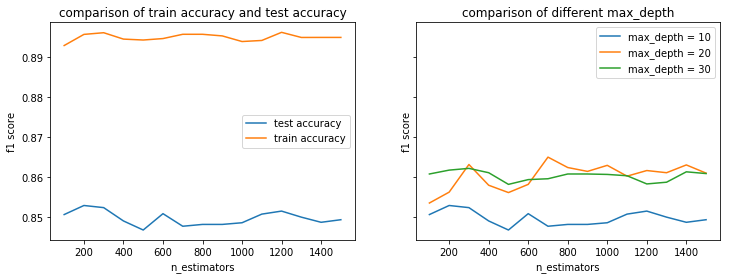

In [41]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
f.set_figwidth(12)
ax1.plot(n_estimators_arr, fscore_test_array[:,0], label = 'test accuracy')
ax1.plot(n_estimators_arr, fscore_train_array[:,0], label = 'train accuracy')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('f1 score')
ax1.set_title('comparison of train accuracy and test accuracy')
ax1.legend()

ax2.plot(n_estimators_arr, fscore_test_array[:,0], label = 'max_depth = 10')
ax2.plot(n_estimators_arr, fscore_test_array[:,1], label = 'max_depth = 20')
ax2.plot(n_estimators_arr, fscore_test_array[:,2], label = 'max_depth = 30')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('f1 score')
ax2.set_title('comparison of different max_depth')
ax2.legend()

plt.show()

**Confusion Matrix**

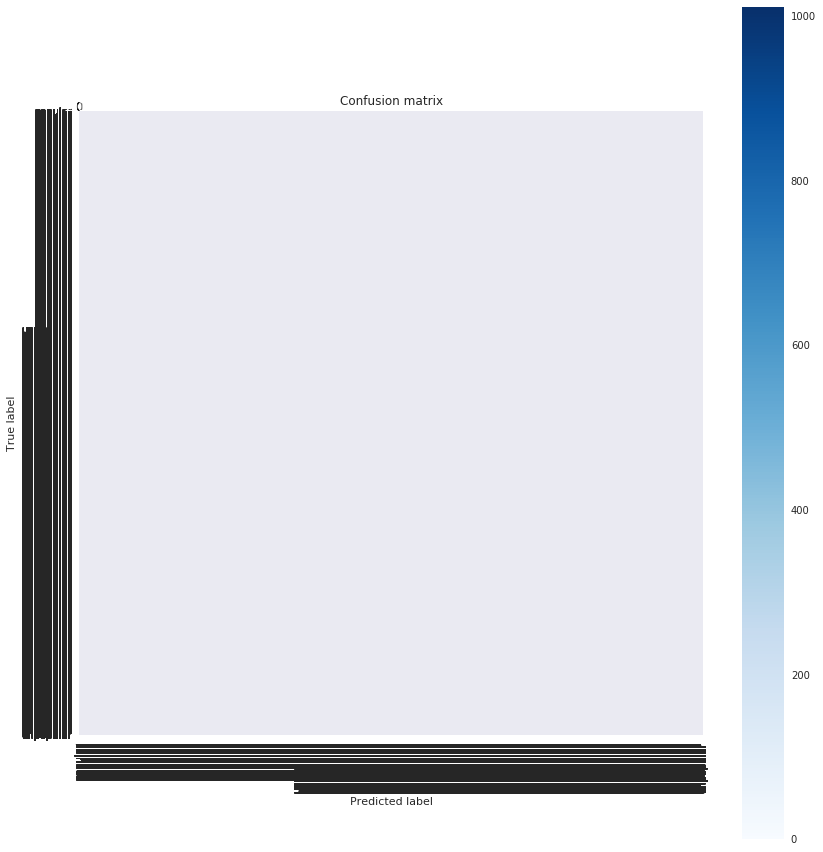

In [53]:
# create confusion matrix
sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, best_model.predict(x_test))

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Function to plot confusion matrix
    Args:
        cm          : confusion matrix
        classes     : array storing the name of categories
        camp        : color bar of confusion matrix
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, 
                      classes=y,
                      title='Confusion matrix')
plt.show()

**Cross validation**

In [52]:
def build_k_indices(y, k_fold):
    """Function to build k indices for k-fold.

    Args:
        y      (numpy array): Matrix output of size N x 1.
        k_fold (int)        : The value k, of k-fold cross validation.
        seed   (int)        : Integer value to seed the random generator.

    Returns:
        k_indices (numpy array) : Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
    """
    seed = 1
    num_row    = y.shape[0]
    interval   = int(num_row / k_fold)
    np.random.seed(seed)
    indices    = np.random.permutation(num_row)
    k_indices  = np.array([indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)])
    return k_indices

def data_split(y, x, k_indices, k):
    """Function to split training data and test data using K-cross validation based on given k_indices.

    Args:
        y         (numpy array): Matrix output of size N x 1.
        tx        (numpy array): Matrix input of size N x D.
        k_indices (numpy array): Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
        k         (int)        : For choosing index in the k_indices

    Returns:
        x_train (numpy array) : Matrix input (features) for training set with size of (ratio*N) x D.
        y_train (numpy array) : Matrix output for training set with size of (ratio*N) x 1.
        x_test  (numpy array) : Matrix input (features) for testing set with size of ((1-ratio)*N) x D.
        y_test  (numpy array) : Matrix output for testing set with size of ((1-ratio)*N) x 1.
    """
    
    train_set_indices               = np.ones(x.shape[0], dtype = bool)
    train_set_indices[k_indices[k]] = False

    x_train = x[train_set_indices]
    y_train = y[train_set_indices]
    
    x_test  = x.iloc[k_indices[k]]
    y_test  = y.iloc[k_indices[k]]
    
    return x_train, y_train, x_test, y_test



# build validation set
k_fold = 10
k_indices = build_k_indices(y, k_fold)

best_n_estimators = 1500
best_max_depth = 30

# best classifier from grid search
clf = RandomForestClassifier(n_estimators=best_n_estimators, 
                             max_depth=best_max_depth,
                             n_jobs=4)

accuracy_arr = np.zeros(k_fold)
para_ = []
# perform 10-fold cross validation
for k in range(k_fold):
    x_train, y_train, x_test, y_test = data_split(y = y, x = x, k_indices=k_indices, k=k)
    clf.fit(x_train, y_train)
    accuracy_arr[k] = f1_score(y_test, clf.predict(x_test), average = 'macro')
    para_.append(clf.feature_importances_)
print('average f1 score = ', np.mean(accuracy_arr))

average f1 score =  0.860810135165


**Important Features**

total number of features: 20
number of features with importance: 0


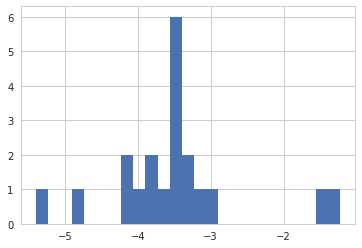

In [54]:
sns.set(style="whitegrid")
feature_importance = np.mean(para_, axis=0)

print('total number of features:', feature_importance.shape[0])
# number of 0's in the feature importance
print('number of features with importance:', np.sum(feature_importance == 0))

# let's see features with non-zero value in log scale
plt.hist(np.log(feature_importance[feature_importance != 0]), bins = 25)
plt.show()

## Q1.2 What are the challenges that music industry faces? 
#### To address this question, we will utilize more about "year" of the songs. We want to see the trend of music popularity

In [149]:
df_msd_reduced.shape

(581965, 30)

## Q1.3 Can we analyze and predict the trend in music industry from years to years?
#### I think we can only conclude which genre is popular in specific year, and we try to find the story behind it. Besides, we can find the duration of popular genre and perhaps it could help us know how long this popular genre would proceed

In [ ]:
import folium

# Get a basic world map.
airports_map = folium.Map(location=[30, 0], zoom_start=2)
# Draw markers on the map.
for name, row in airports.iterrows():
    # For some reason, this one airport causes issues with the map.
    if row["name"] != "South Pole Station":
        airports_map.circle_marker(location=[row["latitude"], row["longitude"]], popup=row["name"])
# Create and show the map.
airports_map.create_map('airports.html')
airports_map